In [42]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.distributions import draw_values
from pymc3.distributions.dist_math import bound
from pymc3.math import logsumexp
import scipy as sp
import seaborn as sns
from theano import shared, tensor as tt
from sklearn.model_selection import train_test_split
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
import graphviz
import arviz as az

In [56]:
admission = pd.read_csv("Admission_Predict_Ver1.1.csv")

In [52]:
admission.head()

Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           2        324          107                  4  4.0   4.5  8.87   
2           3        316          104                  3  3.0   3.5  8.00   
3           4        322          110                  3  3.5   2.5  8.67   
4           5        314          103                  2  2.0   3.0  8.21   

   Research  Chance of Admit   
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65

In [4]:
import pandas_profiling 
pandas_profiling.ProfileReport(admission)

In [17]:
pfr = pandas_profiling.ProfileReport(admission)
pfr.to_file('report.html')

In [6]:
admission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
Serial_No.           400 non-null int64
GRE_Score            400 non-null int64
TOEFL_Score          400 non-null int64
University_Rating    400 non-null int64
SOP                  400 non-null float64
LOR_                 400 non-null float64
CGPA                 400 non-null float64
Research             400 non-null int64
Chance_of_Admit_     400 non-null float64
dtypes: float64(4), int64(5)
memory usage: 28.2 KB


In [57]:
admission = admission.rename(columns={'University Rating':'University_Rating',
                                     'Chance of Admit ':'Chance_of_Admit_',
                                     'Serial No.':'Serial_No.'})

In [58]:
admission['University_Rating'] = admission['University_Rating'].astype('category',copy=True)

In [59]:
admission.head()

Serial_No.  GRE Score  TOEFL Score University_Rating  SOP  LOR   CGPA  \
0           1        337          118                 4  4.5   4.5  9.65   
1           2        324          107                 4  4.0   4.5  8.87   
2           3        316          104                 3  3.0   3.5  8.00   
3           4        322          110                 3  3.5   2.5  8.67   
4           5        314          103                 2  2.0   3.0  8.21   

   Research  Chance_of_Admit_  
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65

### Random Forest

In [ ]:
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
h2o.init()

In [623]:
y = 'Chance_of_Admit_'
x = list(admission.columns)
x.remove(y)
x.remove('Serial_No.')

In [627]:
rf_train, rf_test = train_test_split(admission.iloc[:,1:], test_size = 0.25, random_state=42)
rf_train.head()

GRE Score  TOEFL Score  University_Rating  SOP  LOR   CGPA  Research  \
227        312          110                  2  3.5   3.0  8.53         0   
417        316          103                  3  3.5   2.0  7.68         0   
203        334          120                  5  4.0   5.0  9.87         1   
126        323          113                  3  4.0   3.0  9.32         1   
329        297           96                  2  2.5   1.5  7.89         0   

     Chance_of_Admit_  
227              0.64  
417              0.52  
203              0.97  
126              0.85  
329              0.43

In [630]:
ad_h2o = h2o.H2OFrame(rf_train)
ad_h2o_test = h2o.H2OFrame(rf_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [634]:
ad_h2o_test.shape

(125, 8)

In [663]:
# Initialize the RF estimator:
h2o_rf = H2ORandomForestEstimator(model_id='h2o_rf', seed=1, nfolds=10)
h2o_rf.train(x=x, y=y, training_frame = ad_h2o)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [642]:
h2o_predict = h2o_rf.predict(ad_h2o_test)

drf prediction progress: |████████████████████████████████████████████████| 100%


/Users/ellesmac/anaconda3/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset is missing column 'University Rating': substituting in a column of NaN
  warnings.warn(w)


In [654]:
# include the prediction of h2o random forest to the testing dataset
test.reset_index(drop=True, inplace=True)
test['predict'] = h2o_predict.as_data_frame()
test.head()

GRE Score  TOEFL Score  University_Rating  SOP  LOR   CGPA  Research  \
0        334          116                  4  4.0   3.5  9.54         1   
1        314          108                  4  4.5   4.0  9.04         1   
2        315          105                  2  2.0   2.5  7.65         0   
3        312          109                  3  3.0   3.0  8.69         0   
4        326          112                  3  3.5   3.0  9.05         1   

   Chance_of_Admit_  predict  
0              0.93  0.92230  
1              0.84  0.77080  
2              0.39  0.62250  
3              0.77  0.69710  
4              0.74  0.79745

In [664]:
h2o_rf.model_performance(test_data=ad_h2o_test)


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.003951100390370069
RMSE: 0.06285777907602264
MAE: 0.04545549086570738
RMSLE: 0.03861635003614309
Mean Residual Deviance: 0.003951100390370069


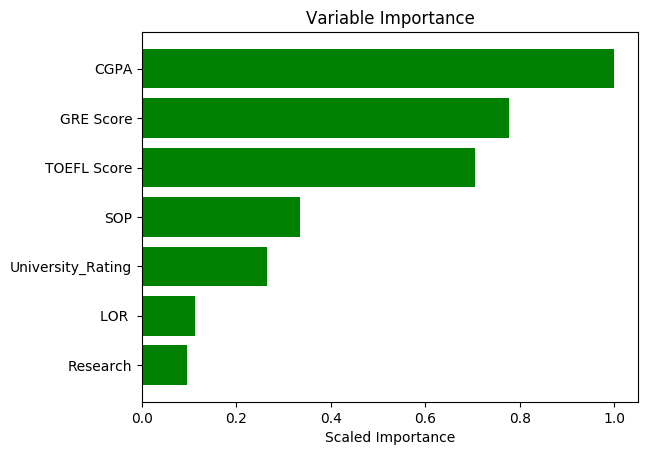

In [694]:
import matplotlib.pyplot as plt
plt.rcdefaults()
fig, ax = plt.subplots()
variables = h2o_rf._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = h2o_rf._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()




## Setting 1. Get data prepared: Treat "Research" as boolean, "University_Rating" as categorical feature, other features as multi-Gaussian

In [60]:
df2 = admission.drop(columns = ['Serial_No.']) 

In [61]:
# correlation (only numeric variable)
admission.corr()['Chance_of_Admit_'].sort_values()

Serial_No.          0.008505
Research            0.545871
LOR                 0.645365
SOP                 0.684137
TOEFL Score         0.792228
GRE Score           0.810351
CGPA                0.882413
Chance_of_Admit_    1.000000
Name: Chance_of_Admit_, dtype: float64

In [30]:
#correlation after one hot encoding (including dummy variables)
df2=pd.get_dummies(df2) 
df2.corr()['Chance_of_Admit_']

GRE_Score              0.810351
TOEFL_Score            0.792228
SOP                    0.684137
LOR_                   0.645365
CGPA                   0.882413
Research               0.545871
Chance_of_Admit_       1.000000
University_Rating_1   -0.305903
University_Rating_2   -0.393661
University_Rating_3   -0.092499
University_Rating_4    0.292087
University_Rating_5    0.487790
Name: Chance_of_Admit_, dtype: float64

If university rating is 1,2 or 3, it is negatively correlated with change of admit

In [62]:
from sklearn.model_selection import train_test_split
df_y = admission['Chance_of_Admit_'] # Target variable

df = admission.drop(columns = ['Serial_No.','Chance_of_Admit_']) 


df=pd.get_dummies(df) # one-hot encoding for "University_Rating_"
df = df.drop(columns = 'University_Rating_1')

# Scale five numerical features
x_num = df.iloc[:,0:5]
meanx = x_num.mean().values
stdx = x_num.std().values
x_num_scaled = ((x_num-meanx)/stdx).values
df.iloc[:,0:5] = x_num_scaled
df.head()
X_train1, X_test1, y_train1, y_test1 = train_test_split(df, df_y, test_size = 0.25, random_state=42)


### Linear Regression

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

#Fit a linear regression on the training data
lin_reg = LinearRegression()
lin_reg.fit(X_train1, y_train1)

# Model parameters
intercept = lin_reg.intercept_
coefs = lin_reg.coef_

# Write the final equation
final_equation = 'grade = %0.4f + ' % intercept

for var, weight in zip(X_train1.columns, coefs):
    final_equation += '%0.2f * %s + ' % (weight, var)

final_equation = ' '.join(final_equation.split(' ')[:-2])

# Display the equation
print('Final Equation from Standard (OLS) Linear Regression:\n')
print(final_equation)

lin_reg.fit(X_train1, y_train1)
predictions = lin_reg.predict(X_test1)
        
        # Metrics
mse = mean_squared_error(y_test1, predictions)
rmse = np.sqrt(mse)
linear_rmse = rmse
print(f'\nrmse:{rmse}')

Final Equation from Standard (OLS) Linear Regression:

grade = 0.0000 + -0.00 * GRE_Score + 0.00 * TOEFL_Score + 0.00 * SOP + -0.00 * LOR_ + -0.00 * CGPA + 0.00 * Research + 1.00 * Chance_of_Admit_ + -0.00 * University_Rating_2 + 0.00 * University_Rating_3 + -0.00 * University_Rating_4 + -0.00 * University_Rating_5

rmse:2.5501317784412075e-16


In [63]:
xtrain_num = X_train1.iloc[:,0:5].values
xtrain_cat = X_train1.iloc[:,5:].values
y_train1 = y_train1.values


In [64]:
elastic_model = ElasticNet(alpha=1.0, l1_ratio=0.5)
elastic_model.fit(X_train1, y_train1)
predictions = elastic_model.predict(X_test1)

# Metrics
elastic_mse = mean_squared_error(y_test1, predictions)
elastic_rmse = np.sqrt(mse)


### Bayesian Regression

In [65]:
with pm.Model() as model1:
    
    beta0 = pm.Normal('beta0', mu=0, sd=1)
    beta_num = pm.MvNormal('beta_num', mu=np.zeros(5), cov=np.identity(5), shape=(5))
    beta_cat = pm.Beta('beta_cat',alpha=[1,1,1,1,1], beta=[1,1,1,1,1], shape=(5))

    
    mu =  beta0+ pm.math.dot(beta_num, xtrain_num.T) + pm.math.dot(beta_cat,xtrain_cat.T)
    sigma = HalfCauchy('sigma', 5)
    
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y_train1)
    # save trace sample
    db = pm.backends.Text('beta_normal')
 


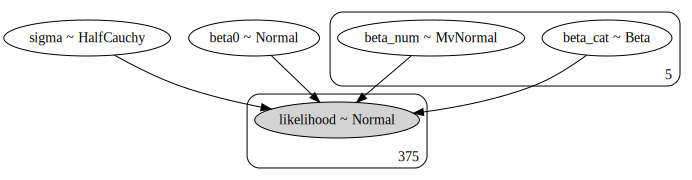

In [66]:
model_to_graphviz(model1)

In [67]:
with model1:
    # start from MAP can make the whole sample set more close to real data
    start = pm.find_MAP()
    trace1 = pm.sample(100000, start = start, nuts_kwargs={'target_accept': 0.95}, trace = db)  # cores = 4,

logp = 514.15, ||grad|| = 2.1649: 100%|██████████| 110/110 [00:00<00:00, 944.50it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_cat, beta_num, beta0]
Sampling 2 chains:  12%|█▏        | 23265/201000 [02:02<15:33, 190.36draws/s]


ValueError: Stop value in slice not supported.

In [95]:
with model1:
    step = pm.Metropolis() # Have a choice of samplers
    trace1_mp = pm.sample(100000, step, progressbar=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta_cat]
>Metropolis: [beta_num]
>Metropolis: [beta0]
Sampling 2 chains: 100%|██████████| 201000/201000 [01:43<00:00, 1951.39draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


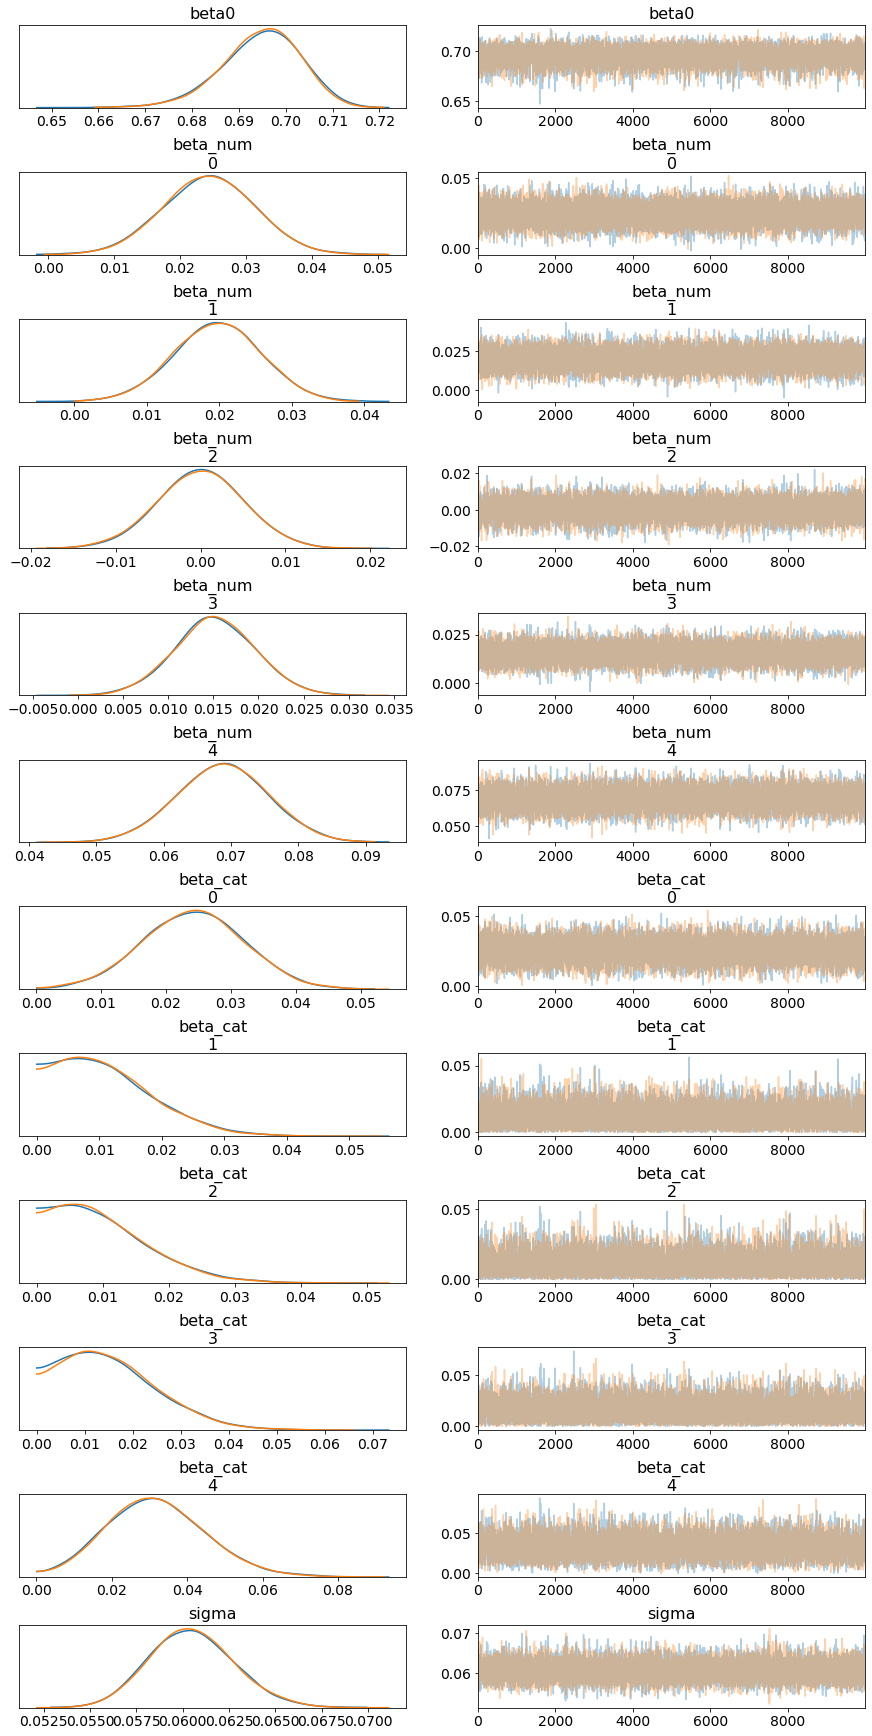

In [358]:
pm.traceplot(trace1);

In [68]:
pm.forestplot(trace1);

NameError: name 'trace1' is not defined

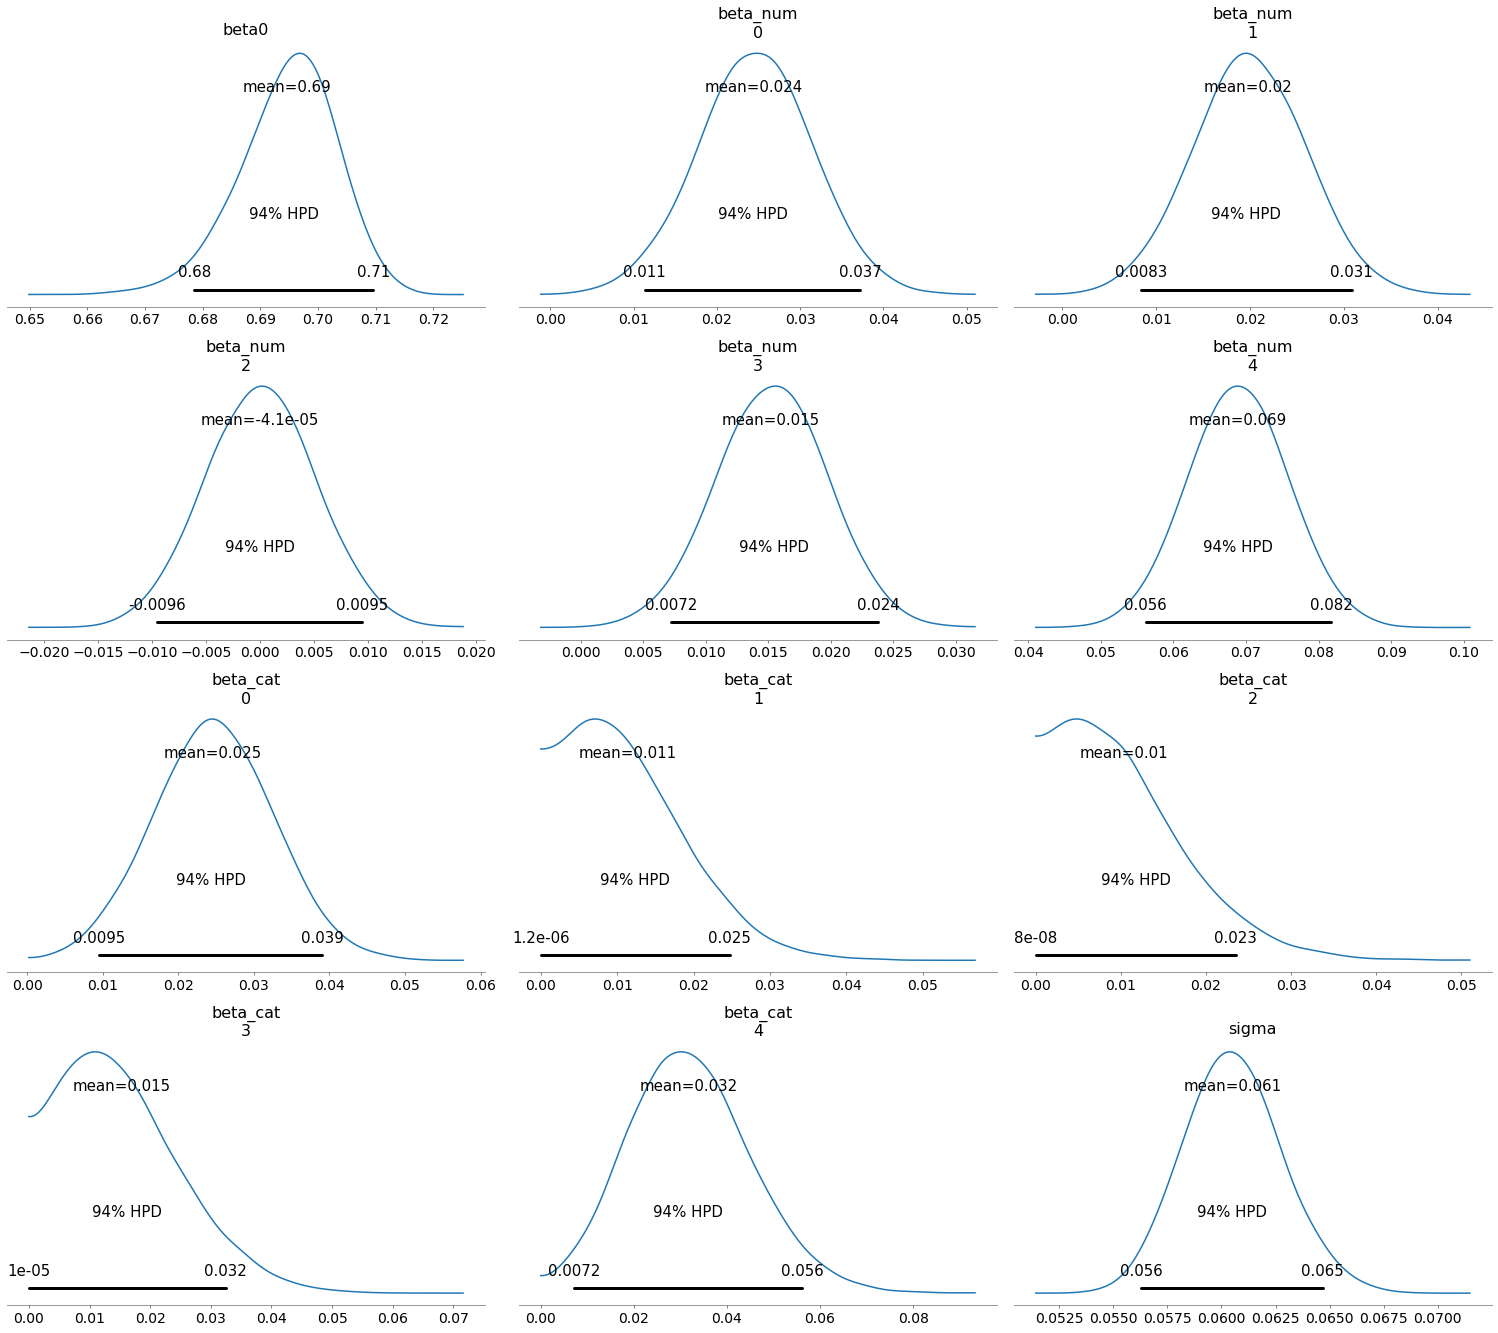

In [38]:
pm.plot_posterior(trace1);

In [39]:
map_estimate = pm.find_MAP(model=model1)

map_estimate

/Users/ellesmac/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 514.15, ||grad|| = 2.1649: 100%|██████████| 110/110 [00:00<00:00, 964.53it/s]  


{'beta0': array(0.71807396),
 'beta_num': array([0.03122158, 0.01914119, 0.00111886, 0.0161528 , 0.06958508]),
 'beta_cat_logodds__': array([-39.65456773, -11.81577592,  -7.96265043,  -5.54538078,
         -3.84442624]),
 'sigma_log__': array(-2.81091252),
 'beta_cat': array([6.00122697e-18, 7.38704101e-06, 3.48107714e-04, 3.89026256e-03,
        2.09503657e-02]),
 'sigma': array(0.06015008)}

In [40]:
beta_map_est =np.array([0.7225, 0.03342452, 0.01691233, 0.00336232, 0.01229123, 0.06452208,4.97168049e-14,
                        2.63784144e-05,0.00667802,0.00943762, 0.02710066])
beta_map_est

array([7.22500000e-01, 3.34245200e-02, 1.69123300e-02, 3.36232000e-03,
       1.22912300e-02, 6.45220800e-02, 4.97168049e-14, 2.63784144e-05,
       6.67802000e-03, 9.43762000e-03, 2.71006600e-02])

In [52]:
pm.summary(trace1)

/Users/ellesmac/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


mean        sd  mc_error       hpd_2.5  hpd_97.5  \
beta0        0.694504  0.008301  0.000102  6.784918e-01  0.710554   
beta_num__0  0.024539  0.006884  0.000054  1.126738e-02  0.038078   
beta_num__1  0.019720  0.005950  0.000042  8.089912e-03  0.031387   
beta_num__2  0.000001  0.005001  0.000037 -9.679420e-03  0.009875   
beta_num__3  0.015214  0.004329  0.000028  6.554999e-03  0.023595   
beta_num__4  0.068708  0.006743  0.000047  5.532686e-02  0.081722   
beta_cat__0  0.024413  0.007794  0.000073  9.436602e-03  0.039880   
beta_cat__1  0.011429  0.007592  0.000074  3.640793e-07  0.025668   
beta_cat__2  0.010444  0.007430  0.000082  2.641729e-08  0.024409   
beta_cat__3  0.015473  0.009900  0.000108  8.403711e-06  0.033587   
beta_cat__4  0.032227  0.012998  0.000135  6.623818e-03  0.057296   
sigma        0.060487  0.002236  0.000014  5.619349e-02  0.064969   

                    n_eff      Rhat  
beta0         7595.233304  1.000557  
beta_num__0  18225.135659  1.000205  
beta_num__1  22206.047081  0.999996  
beta_num__2  19127.505039  0.999961  
beta_num__3  21986.018016  1.000048  
beta_num__4  19679.584022  0.999995  
beta_cat__0  11851.079203  1.000052  
beta_cat__1  10461.270807  1.000667  
beta_cat__2   8383.685188  1.000486  
beta_cat__3   8213.033490  1.000004  
beta_cat__4   8542.377450  1.000081  
sigma        23125.047437  0.999950

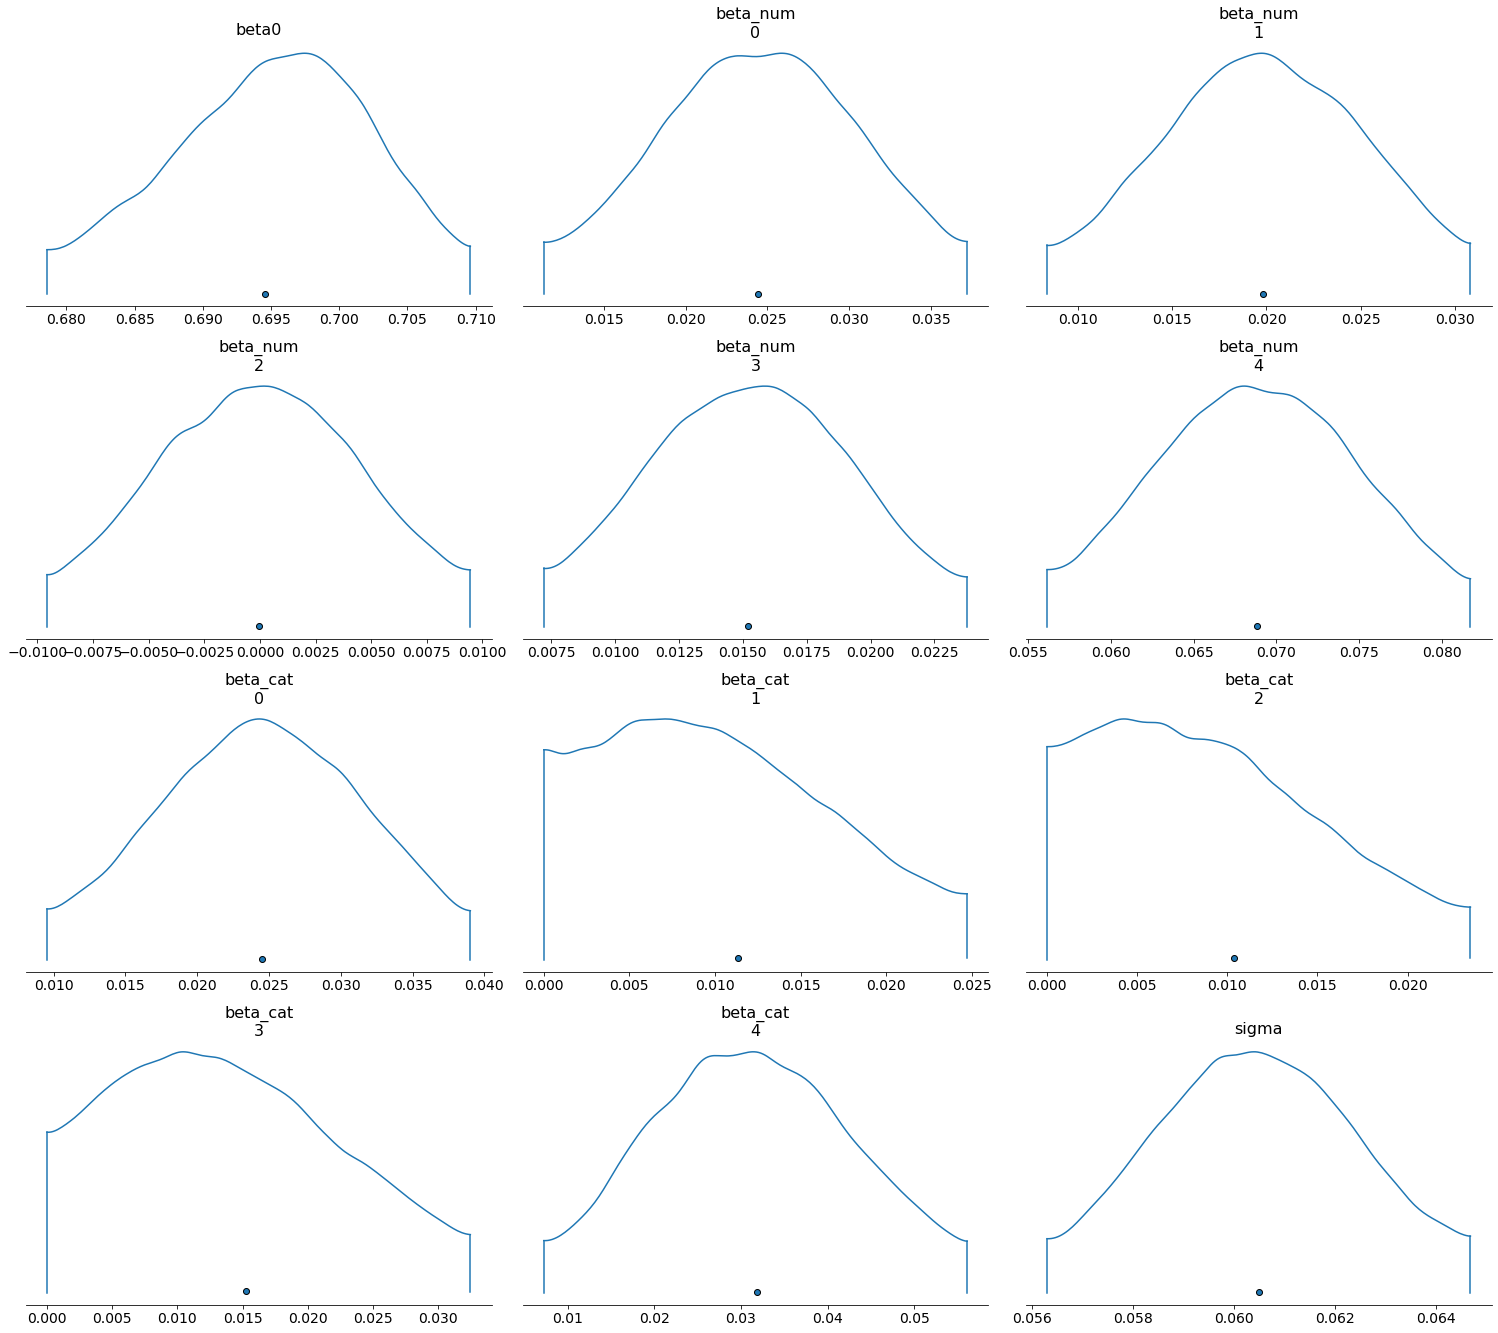

In [45]:
pm.densityplot(trace1);

In [43]:
waic = az.waic(trace1)
waic

Computed from 20000 by 375 log-likelihood matrix

        Estimate       SE
IC_waic -1093.85    42.27
p_waic     13.08        -

In [665]:
# Evaluate the performance of Sampling method by RMSE
def evaluate_trace(trace, X_test, y_test):
    beta = pm.summary(trace)[['mean']].iloc[:11,].values
    beta0_hat = beta[0]
    betaj_hat = beta[1:]
    y_hat = beta0_hat+np.dot(betaj_hat.T,X_test.T)
    
    # Plot the observations and predictions
    plt.figure(figsize=(12,12))
#     plt.hist(y_test, label = 'Observed')
#     plt.hist(y_hat, label = 'Estimate')
    dict_y={'y_test':y_test1, 'y_hat':y_hat.ravel()}
    df_y=pd.DataFrame(dict_y)

    g=sns.jointplot(x='y_test', y='y_hat' , data=df_y, kind='kde')
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':r')  
    
    #plt.legend(prop={'size': 14})
    plt.xlabel('Observed y'); plt.ylabel('Estimated y');
    plt.title('Observed and Estimated Values')
    plt.show()
    

    rmse = np.sqrt(np.sum((y_hat - y_test.values)**2)/len(y_test))
    return rmse
    


/Users/ellesmac/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])
/Users/ellesmac/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 864x864 with 0 Axes>

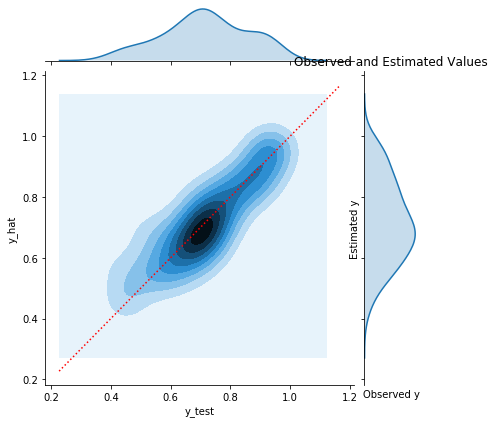

0.05960110558536677

In [666]:
rmse1 = evaluate_trace(trace1, X_test1, y_test1)
rmse1

In [56]:
# X_train1['y'] = y_train1

/Users/ellesmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [378]:
# this is the sample set save when sampling
# change the directory

chain0= pd.read_csv('beta_normal/chain-0.csv')
chain1 = pd.read_csv('beta_normal/chain-1.csv')
chain0 = chain1.iloc[5000:,:]
chain1 = chain1.iloc[5000:,:]
sample_df = pd.concat([chain0, chain1], axis=0, sort=False)



In [457]:
sample_df.head()

beta0  beta_num__0  beta_num__1  beta_num__2  beta_num__3  \
5000  0.682656     0.031353     0.019674     0.009236     0.018278   
5001  0.691868     0.031674     0.012273    -0.013541     0.018811   
5002  0.690514     0.017447     0.033935     0.010497     0.013917   
5003  0.684594     0.023814     0.024193    -0.004487     0.011124   
5004  0.690690     0.020056     0.020462    -0.001926     0.012469   

      beta_num__4  beta_cat_logodds____0  beta_cat_logodds____1  \
5000     0.042018              -4.002971              -4.073392   
5001     0.086846              -3.548481              -4.414600   
5002     0.052884              -3.645901              -3.786571   
5003     0.062624              -3.302531              -5.169611   
5004     0.065086              -3.567082              -4.739611   

      beta_cat_logodds____2  beta_cat_logodds____3  beta_cat_logodds____4  \
5000              -3.577256              -3.309137              -2.942335   
5001              -4.316529              -3.969862              -3.808109   
5002              -5.284274              -4.203825              -3.149275   
5003              -5.392570              -3.307688              -3.106239   
5004              -5.278467              -3.900161              -2.779811   

      sigma_log__  beta_cat__0  beta_cat__1  beta_cat__2  beta_cat__3  \
5000    -2.812123     0.017934     0.016735     0.027192     0.035259   
5001    -2.799120     0.027964     0.011955     0.013170     0.018526   
5002    -2.784045     0.025434     0.022171     0.005045     0.014718   
5003    -2.829995     0.035484     0.005655     0.004530     0.035308   
5004    -2.806286     0.027463     0.008666     0.005074     0.019837   

      beta_cat__4     sigma  
5000     0.050100  0.060077  
5001     0.021708  0.060864  
5002     0.041120  0.061788  
5003     0.042851  0.059013  
5004     0.058425  0.060429

In [577]:
from IPython.core.pylabtools import figsize
figsize(9, 7)

def query_model(trace, test_set, y_test, sample_df, index):
     # Dictionary of all sampled values for each parameter
     
    print(pd.DataFrame(X_test1.iloc[index,:]))
    observation = pd.DataFrame(np.array(X_test1.iloc[index,:]).reshape(1, 10))
    observation.columns = ['beta_num__0', 'beta_num__1','beta_num__2', 'beta_num__3', 'beta_num__4',
                          'beta_cat__0', 'beta_cat__1', 'beta_cat__2', 'beta_cat__3','beta_cat__4']
    
    
    
    observation['beta0'] = 1
    

    
    var_weights = sample_df

    weights = np.array(var_weights.ix[:, observation.columns])
    estimates = np.dot(weights, np.array(observation).reshape(11, 1))
    
    

    plt.figure(figsize(8, 8))
    sns.distplot(estimates[:, 0], hist = True, kde = True,
                 hist_kws = {'edgecolor': 'k', 'color': 'navy'})
    
    # beta mean yhat line
    
    beta = pm.summary(trace)[['mean']].iloc[:11,].values
    beta0_hat = beta[0]
    betaj_hat = beta[1:]
    yhat = beta0_hat+np.dot(betaj_hat.T,np.array(observation.iloc[:,:10]).reshape(10, 1))
    
    plt.axvline(x= yhat, color = 'g', label = 'beta mean', linestyle = '--')
    
    # true y
    plt.axvline(x= y_test1.iloc[index,], color = 'r', label = 'true y')
    
    plt.legend()
    plt.title('Density Plot for New Observation');
    plt.xlabel('Estimate'); plt.ylabel('Density');
    
    print('Average Estimate = %0.4f' % np.median(estimates))
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

In [721]:
# if directly using trace
# !! need to change here: var_weights = sample_df in query_mode function
df_beta0 = pd.DataFrame(trace1.get_values('beta0'))
df_beta_num = pd.DataFrame(trace1.get_values('beta_num'))
df_beta_cat = pd.DataFrame(trace1.get_values('beta_cat'))


beta_df = pd.concat([df_beta0, df_beta_num,  df_beta_cat], axis=1, sort=False)

beta_df.columns = ['beta0','beta_num__0', 'beta_num__1','beta_num__2', 'beta_num__3', 'beta_num__4',
                          'beta_cat__0', 'beta_cat__1', 'beta_cat__2', 'beta_cat__3','beta_cat__4']
    
beta_df.head()

beta0  beta_num__0  beta_num__1  beta_num__2  beta_num__3  beta_num__4  \
0  0.686005     0.020653     0.023810     0.001443     0.016517     0.067936   
1  0.685864     0.019797     0.023151     0.001074     0.016126     0.067259   
2  0.708818     0.022368     0.019239     0.002280     0.017386     0.060619   
3  0.707749     0.022447     0.020957     0.003047     0.018802     0.060441   
4  0.690320     0.024419     0.019904     0.007276     0.016813     0.065733   

   beta_cat__0  beta_cat__1  beta_cat__2  beta_cat__3  beta_cat__4  
0     0.037824     0.028953     0.008109     0.014515     0.036361  
1     0.037307     0.040121     0.008795     0.014458     0.037645  
2     0.030147     0.004241     0.008495     0.004837     0.020818  
3     0.026525     0.004535     0.006280     0.005104     0.022128  
4     0.025903     0.002793     0.014553     0.005662     0.034571

                          361
GRE Score            1.551817
TOEFL Score          1.448239
SOP                  0.631683
LOR                  0.017289
CGPA                 1.593154
Research             1.000000
University_Rating_2  0.000000
University_Rating_3  0.000000
University_Rating_4  1.000000
University_Rating_5  0.000000


/Users/ellesmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/Users/ellesmac/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/ellesmac/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


Average Estimate = 0.9108
5% Estimate = 0.8964    95% Estimate = 0.9254


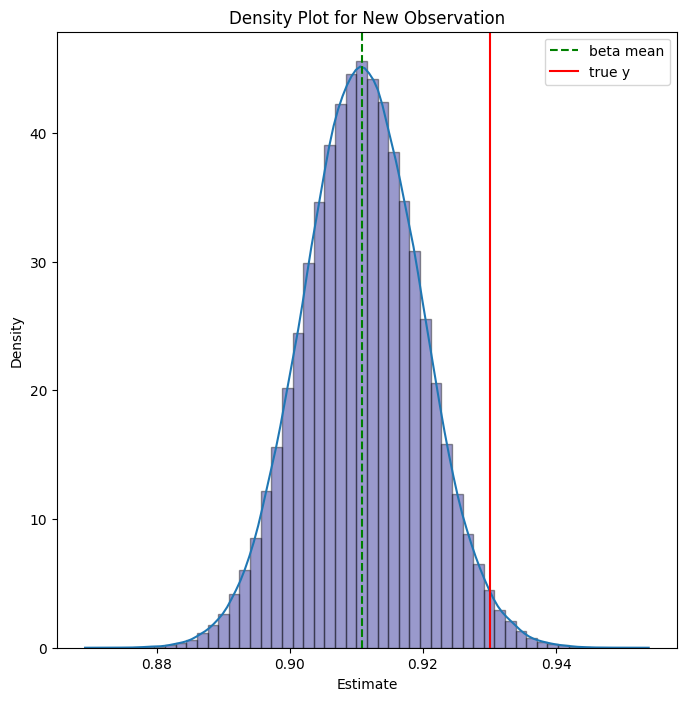

In [722]:
# can use sample_df(save from sampling) or beta_df (getting from trace1)
query_model(trace1, X_test1, y_test1, beta_df, 0)

In [678]:
# calculate rmse

def query_rmse(trace, x_test, y_test):
    pred = []
    for i in range(X_test1.shape[0]):
        observation = pd.DataFrame(np.array(X_test1.iloc[i,:]).reshape(1, 10))
        observation.columns = ['beta_num__0', 'beta_num__1','beta_num__2', 'beta_num__3', 'beta_num__4',
                          'beta_cat__0', 'beta_cat__1', 'beta_cat__2', 'beta_cat__3','beta_cat__4']
    
    
    
        observation['beta0'] = 1
        
        var_weights = sample_df

        weights = np.array(var_weights.ix[:, observation.columns])
        estimates = np.dot(weights, np.array(observation).reshape(11, 1))

    
        pred.append(np.median(estimates))
        
        
    mse = mean_squared_error(y_test1, np.array(pred))
    rmse = np.sqrt(mse)
    
    return rmse



In [695]:
bayes_rmse = query_rmse(trace1, X_test1, y_test1)

/Users/ellesmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
/Users/ellesmac/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:808: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


### MSE comparison
- Linear 
- Random Forest
- Bayesian Linear Model

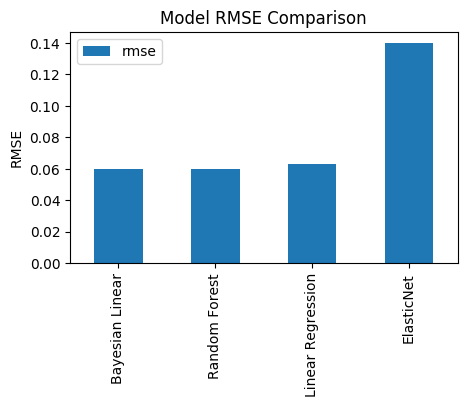

In [713]:
data = [linear_rmse, rf_rmse, bayes_rmse, elastic_rmse] 
  
# Create the pandas DataFrame 
rmse_result = pd.DataFrame(data, columns = ['rmse'], index = ['Random Forest', 'Linear Regression', 'Bayesian Linear', 'ElasticNet']) 

figsize(5, 3)
# Root mean squared error
ax = rmse_result.sort_values('rmse', ascending = True).plot.bar(y = 'rmse')
plt.title('Model RMSE Comparison'); plt.ylabel('RMSE');


## Setting 2: Compare pooling vs unpooling Model

### Complete pooling model
treat all universities rank same and estimate single admission chance. 

$ y = \alpha + \beta x_{i} + \epsilon_{i} $

In [69]:
df2_y = admission['Chance_of_Admit_'] # Target variable

df2 = admission.drop(columns = ['Serial_No.', 'Chance_of_Admit_']) 
df2.head()


GRE Score  TOEFL Score University_Rating  SOP  LOR   CGPA  Research
0        337          118                 4  4.5   4.5  9.65         1
1        324          107                 4  4.0   4.5  8.87         1
2        316          104                 3  3.0   3.5  8.00         1
3        322          110                 3  3.5   2.5  8.67         1
4        314          103                 2  2.0   3.0  8.21         0

In [70]:
# Scale five numerical features
from sklearn.model_selection import train_test_split

x_num2 = df2.iloc[:,[0,1,3,4,5]]
meanx2 = x_num2.mean().values
stdx2 = x_num2.std().values
x_num_scaled2 = ((x_num2-meanx2)/stdx2).values
df2.iloc[:,[0,1,3,4,5]] = x_num_scaled2

df2.head()

# 6 predictors (x's)
df2_feature = df2.iloc[:,[0,1,3,4,5,6]]
df2_feature.head()
#X_train2, X_test2, y_train2, y_test2 = train_test_split(df2, df2_y, test_size = 0.25, random_state=42)

GRE Score  TOEFL Score       SOP      LOR       CGPA  Research
0   1.817417     1.777086  1.136222  1.097845  1.775029         1
1   0.666481    -0.031569  0.631683  1.097845  0.485373         1
2  -0.041788    -0.524839 -0.377395  0.017289 -0.953088         1
3   0.489414     0.461700  0.127144 -1.063267  0.154692         1
4  -0.218855    -0.689262 -1.386473 -0.522989 -0.605873         0

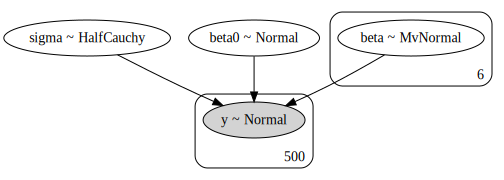

In [71]:
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz

rating = df2.University_Rating.values
admit = df2_y.values

with pm.Model() as pooled_model:

    beta0 = pm.Normal('beta0',0,sigma = 1e5)
    beta = pm.MvNormal('beta', mu = np.zeros(6), cov = np.identity(6), shape=6)
    sigma = pm.HalfCauchy('sigma', 5)

    theta = beta0 + pm.math.dot(beta , (df2_feature.values).T)

    y = pm.Normal('y', theta, sigma=sigma, observed=admit)
model_to_graphviz(pooled_model)

In [72]:
with pooled_model:
    pooled_trace = sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, beta0]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:47<00:00, 460.74draws/s]


point estimates of the slope and intercept for the complete pooling model

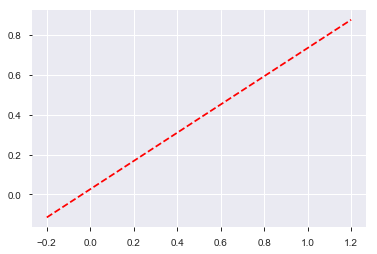

In [110]:
m0 = pooled_trace['beta0'].mean()
b0 = pooled_trace['beta'].mean()

xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, m0*xvals+b0, 'r--');

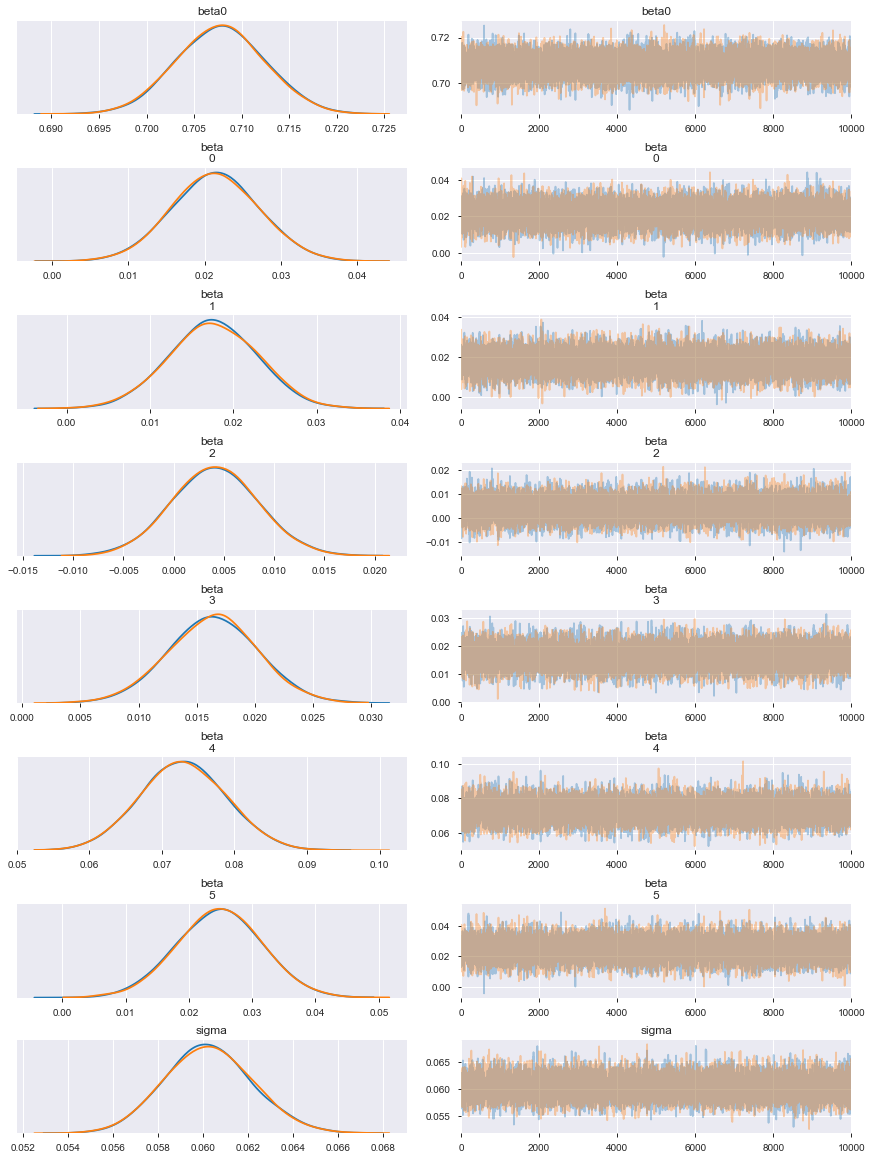

In [111]:
pm.traceplot(pooled_trace);

### Unpooled Model

Each model for each university rating: different intercept, same slope  
$ y_{i} = \alpha_{[j]i} + \beta x_{i} + \epsilon_{i} $

In [112]:
# Remove index for University Rating 
rating = admission.University_Rating
rating_lookup = dict(zip(rating.unique(), range(len(rating.unique()))))
rating = admission.University_Rating.replace(rating_lookup).values

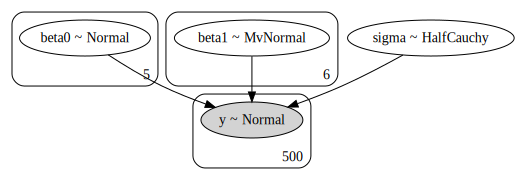

In [113]:
with Model() as unpooled_model:

    beta0 = pm.Normal('beta0', 0, sd = 1, shape=5)
    beta1 = pm.MvNormal('beta1', mu = np.zeros(6), cov = np.identity(6), shape = (6))
    sigma = HalfCauchy('sigma', 5)

    theta = beta0[rating] +  pm.math.dot(beta1 , (df2_feature.values).T)

    y = Normal('y', theta, sigma=sigma, observed=admit)
model_to_graphviz(unpooled_model)

In [114]:
with unpooled_model:
    unpooled_trace = sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta1, beta0]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:44<00:00, 495.52draws/s]


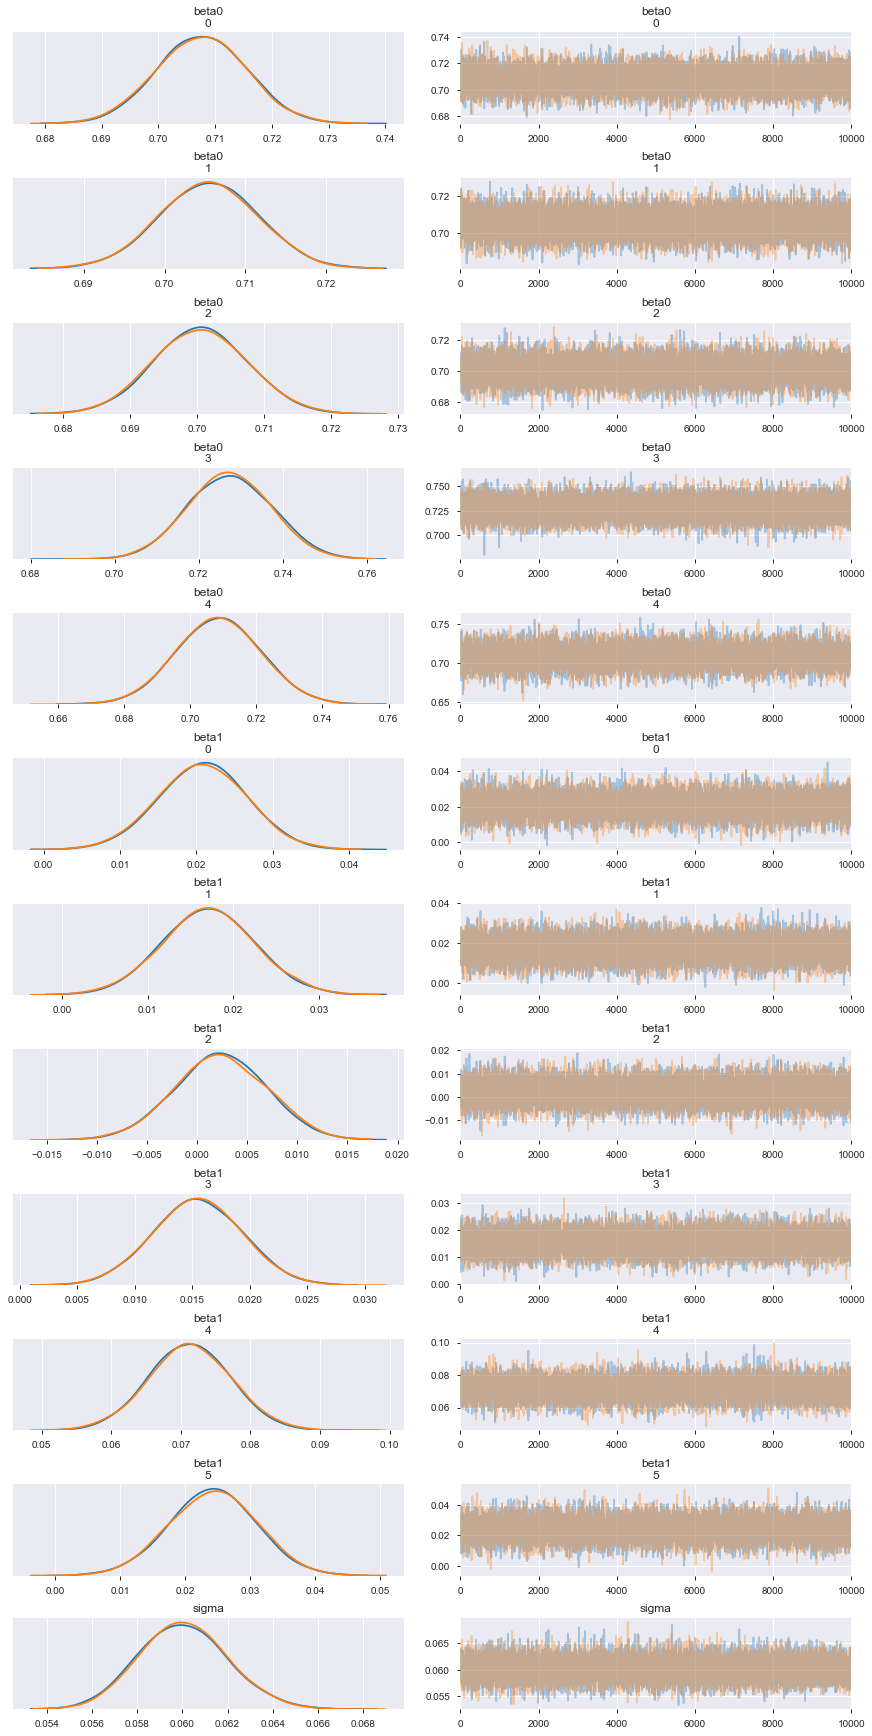

In [111]:
pm.traceplot(unpooled_trace);

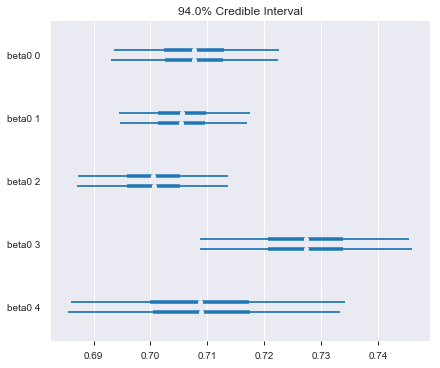

In [115]:
pm.forestplot(unpooled_trace, var_names=['beta0']);

In [116]:
unpooled_estimates = pd.Series(unpooled_trace['beta0'].mean(axis=0))
unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0))

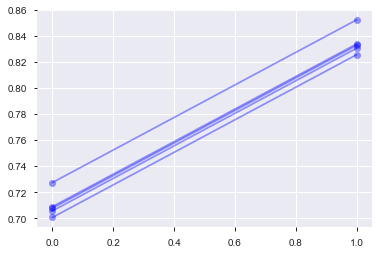

In [117]:
xvals = np.arange(2)
b = unpooled_trace['beta0'].mean(axis=0)
m = unpooled_trace['beta1'].mean(axis=0)
for bi in zip(b):
    plt.plot(xvals, m[0]*xvals + m[0]*xvals + m[0]*xvals + m[0]*xvals + m[0]*xvals + m[0]*xvals + bi, 'bo-', alpha=0.4)

(0.7, 0.75)

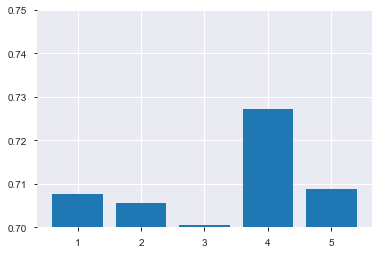

In [118]:
# compare admission rate for each university rating group
unpool = unpooled_trace['beta0'].mean(axis=0)
unpool

x = []
for i in range(1,6):
    x.append(i) 

plt.bar(x,unpool)
plt.ylim(0.7,0.75)

In [119]:
admission.groupby(['University_Rating']).mean()

Serial_No.   GRE Score  TOEFL Score       SOP      LOR   \
University_Rating                                                            
1                  281.558824  304.911765   100.205882  1.941176  2.426471   
2                  249.555556  309.134921   103.444444  2.682540  2.956349   
3                  247.574074  315.030864   106.314815  3.308642  3.401235   
4                  275.809524  323.304762   110.961905  4.000000  3.947619   
5                  207.753425  327.890411   113.438356  4.479452  4.404110   

                       CGPA  Research  Chance_of_Admit_  
University_Rating                                        
1                  7.798529  0.294118          0.562059  
2                  8.177778  0.293651          0.626111  
3                  8.500123  0.537037          0.702901  
4                  8.936667  0.780952          0.801619  
5                  9.278082  0.876712          0.888082

In [63]:
admission.groupby(['University_Rating']).size()

University_Rating
1     34
2    126
3    162
4    105
5     73
dtype: int64

This result is showing that groups which have less observation result in extreme estimate.Therefore, we would like to implement hierarchical model

NameError: name 'sample_counties' is not defined

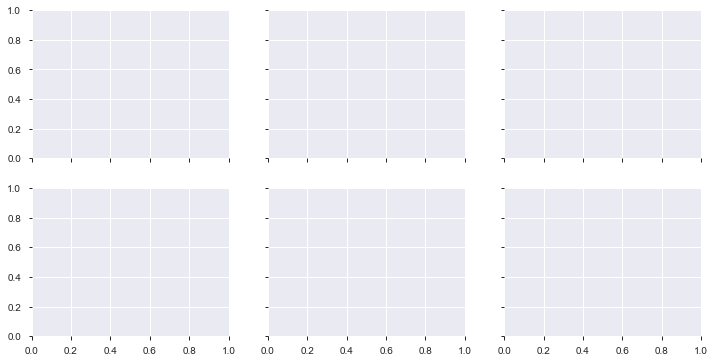

In [109]:
rating_list = ('Rating 1', 'Rating 2', 'Rating 3',
                    'Rating 4', 'Rating 5')

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace['beta1'].mean()
for i,c in enumerate(sample_counties):
    y = admission.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_estimates[c]

    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b)
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

In [86]:
rating_list = ['Rating1','Rating2','Rating3','Rating4','Rating5']
unpooled_estimates = pd.Series(unpooled_trace['beta0'].mean(axis=0), index = rating_list)
unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0), index = rating_list)
print(unpooled_estimates)
print(unpooled_se)

Rating1    0.707659
Rating2    0.705521
Rating3    0.700454
Rating4    0.727435
Rating5    0.708553
dtype: float64
Rating1    0.007805
Rating2    0.006083
Rating3    0.007007
Rating4    0.009772
Rating5    0.012791
dtype: float64


## Hierarchical Model

### Partial Pooling
for partial pooling, we don't need features

$ \alpha = \frac{(n_{j}/\sigma^2_{y})y_{j} + (1/\sigma^2_{\alpha})y}{(n_{j}/\sigma^2_{y})+ (1/\sigma^2_{\alpha})} $

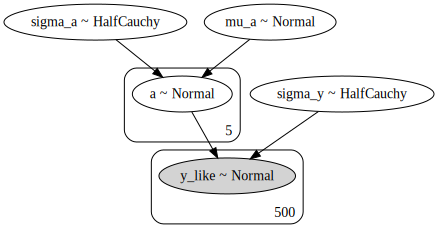

In [87]:
with Model() as partial_pooling:

    # Priors
    mu_a = Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = HalfCauchy('sigma_a', 5)

    # Random intercepts
    a = Normal('a', mu=mu_a, sigma=sigma_a, shape=5)

    # Model error
    sigma_y = HalfCauchy('sigma_y',5)

    # Expected value
    y_hat = a[rating]

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=admit)

model_to_graphviz(partial_pooling)

In [90]:
with partial_pooling :
    partial_trace = sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, a, sigma_a, mu_a]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:17<00:00, 1229.01draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


(<Figure size 432x360 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2320d8d0>],
       dtype=object))

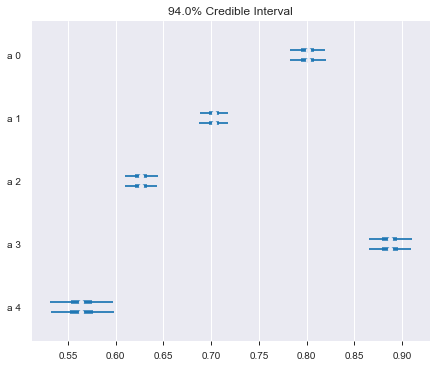

In [91]:
pm.forestplot(partial_trace, var_names = ['a'])

University rating = 5 is showing the largest uncertainty. 

#### Unpooled vs Partial pooling

In [66]:
admission.head()

Serial_No.  GRE Score  TOEFL Score University_Rating  SOP  LOR   CGPA  \
0           1        337          118                 4  4.5   4.5  9.65   
1           2        324          107                 4  4.0   4.5  8.87   
2           3        316          104                 3  3.0   3.5  8.00   
3           4        322          110                 3  3.5   2.5  8.67   
4           5        314          103                 2  2.0   3.0  8.21   

   Research  Chance_of_Admit_  
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65

[0.80107829 0.70289947 0.62638115 0.88699706 0.56428462]


(0.5, 0.9)

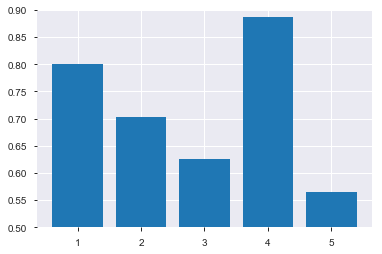

In [92]:
partial = partial_trace['a'].mean(axis=0)
partial
print(partial)
x = []
for i in range(1,6):
    x.append(i) 

plt.bar(x,partial)
plt.ylim(0.5,0.9)

In [96]:
true_chance = admission.groupby(['University_Rating']).mean()['Chance_of_Admit_']

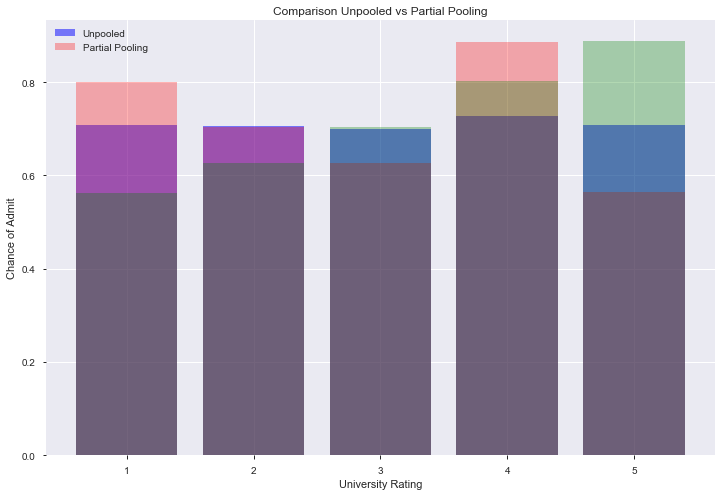

In [101]:
fig, ax = plt.subplots(figsize = (12,8))
x = []
for i in range(1,6):
    x.append(i) 

ax.bar(x,unpool, alpha = 0.5, color = 'blue')
ax.bar(x,partial, color = 'red',alpha = 0.3)
ax.bar(x, true_chance, color = 'green', alpha = 0.3)
ax.set_title("Comparison Unpooled vs Partial Pooling")
ax.set_xlabel('University Rating')
ax.set_ylabel('Chance of Admit')
ax.legend(labels = ['Unpooled','Partial Pooling'])
ax.ylim = [0.4,0.9]

### Varying intercept, coefficient

In [104]:
df2_feature.head()


GRE Score  TOEFL Score       SOP      LOR       CGPA  Research
0   1.817417     1.777086  1.136222  1.097845  1.775029         1
1   0.666481    -0.031569  0.631683  1.097845  0.485373         1
2  -0.041788    -0.524839 -0.377395  0.017289 -0.953088         1
3   0.489414     0.461700  0.127144 -1.063267  0.154692         1
4  -0.218855    -0.689262 -1.386473 -0.522989 -0.605873         0

In [105]:
with Model() as varying_intercept_slope:

    # Priors
    mu_a = Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = HalfCauchy('sigma_a', 5)
    mu_b = Normal('mu_b', mu=0., sigma=1e5)
    sigma_b = HalfCauchy('sigma_b', 5)

    # Random intercepts
    a = Normal('a', mu=mu_a, sigma=sigma_a, shape=5)
    # Random slopes
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=5)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a[rating] + b[rating] * (df2_feature.GRE_Score.values 
                                     + df2_feature.TOEFL_Score.values + df2_feature.SOP.values 
                                     + df2_feature.LOR_.values+ df2_feature.CGPA.values)

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=admit)

model_to_graphviz(varying_intercept_slope)

AttributeError: 'DataFrame' object has no attribute 'GRE_Score'

In [96]:
with varying_intercept_slope :
    varying_intercept_trace = sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:59<00:00, 372.57draws/s] 
There were 1985 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6365384936036576, but should be close to 0.8. Try to increase the number of tuning steps.
There were 797 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


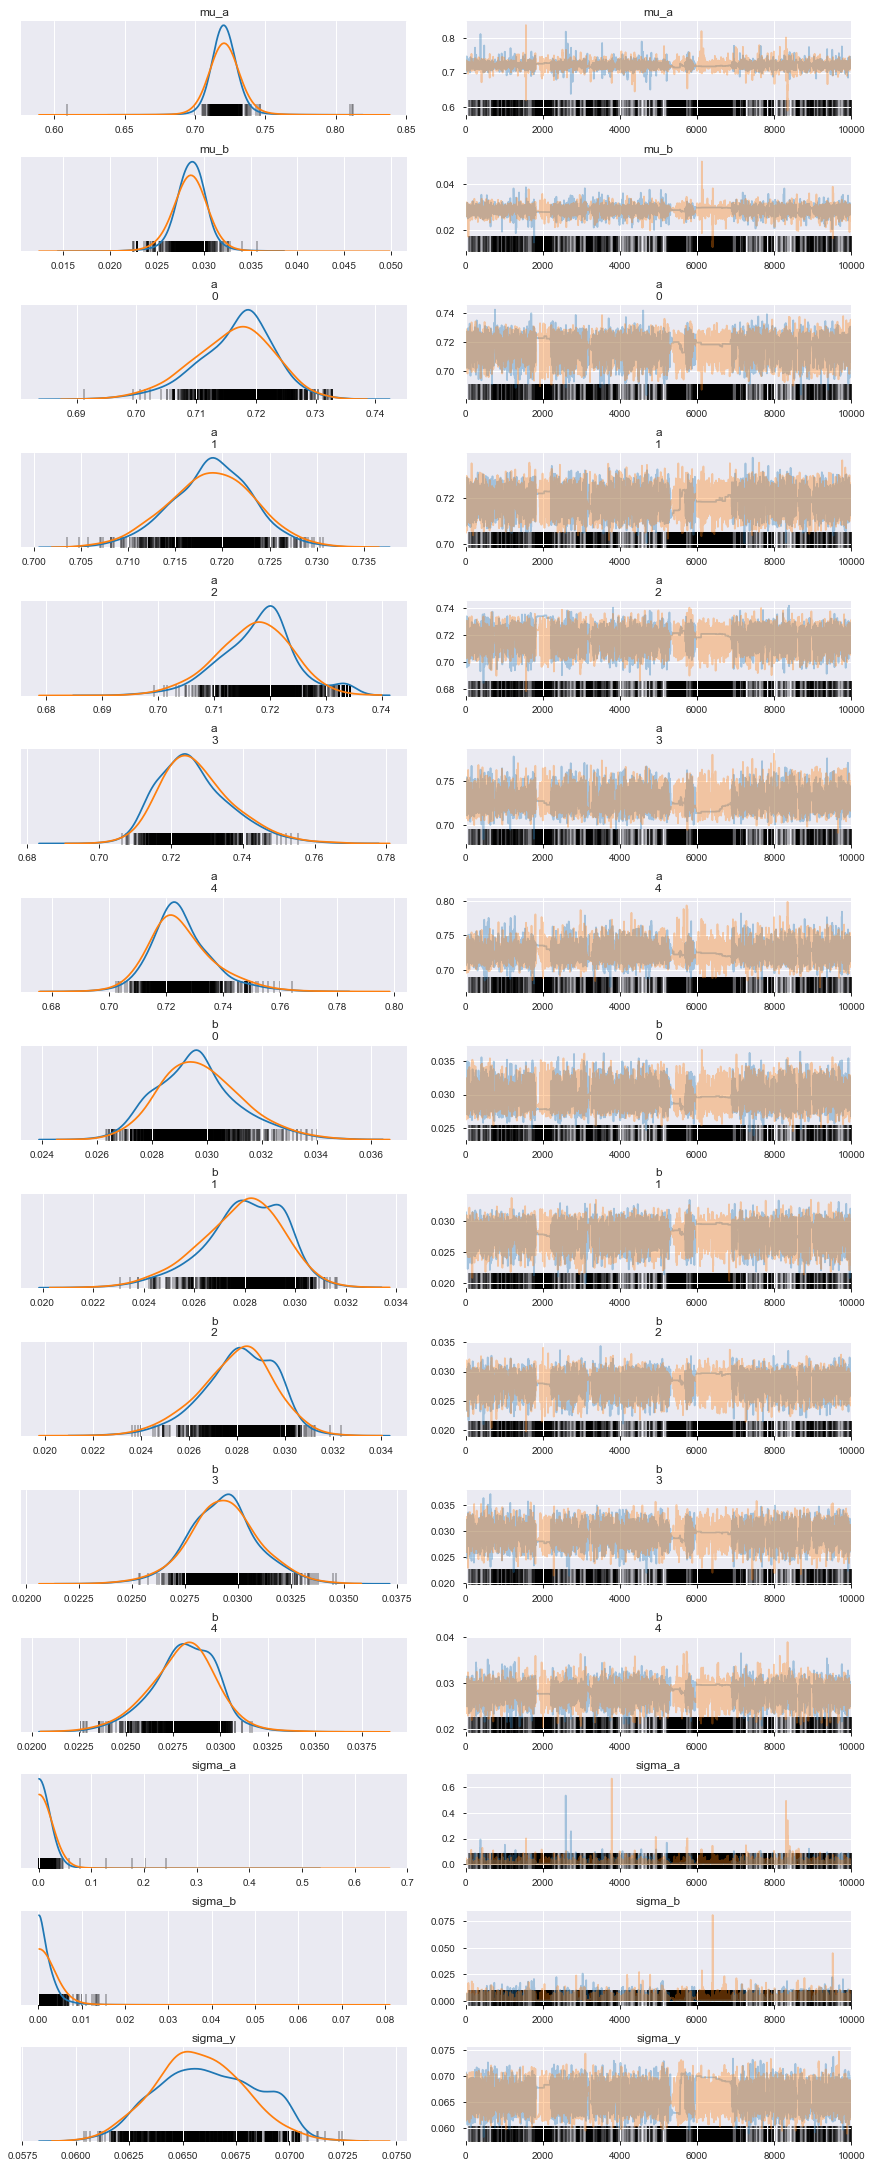

In [97]:
pm.traceplot(varying_intercept_trace);

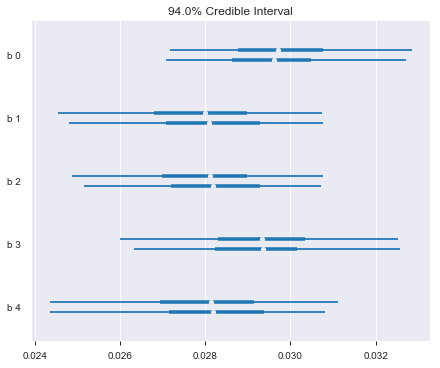

In [100]:
pm.forestplot(varying_intercept_trace, var_names = ['b']);

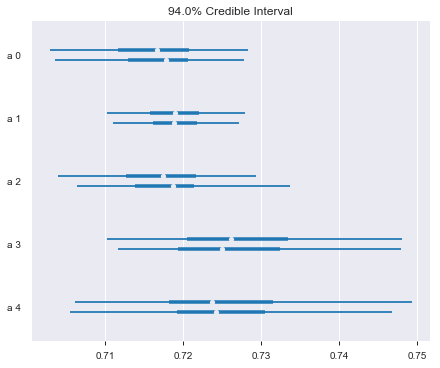

In [101]:
pm.forestplot(varying_intercept_trace, var_names = ['a']);

[0.71632387 0.71889486 0.71747834 0.72704745 0.72550221] [0.02974582 0.02790601 0.02802185 0.02930081 0.02805438]


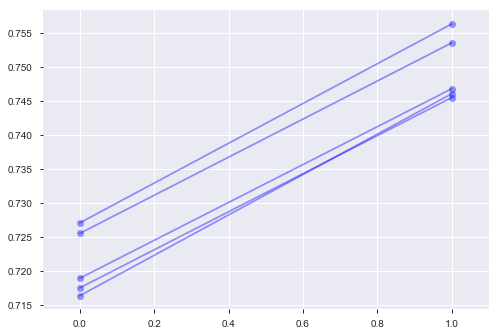

In [107]:
xvals = np.arange(2)
b = varying_intercept_trace['a'].mean(axis=0)
m = varying_intercept_trace['b'].mean(axis=0)
print(b,m)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);

In [102]:
varying = varying_intercept_trace['a'].mean(axis=0)
varying

x = []
for i in range(0,5):
    x.append(i) 

plt.bar(x,varying)
plt.ylim(0.7,0.75)

NameError: name 'varying_intercept_trace' is not defined

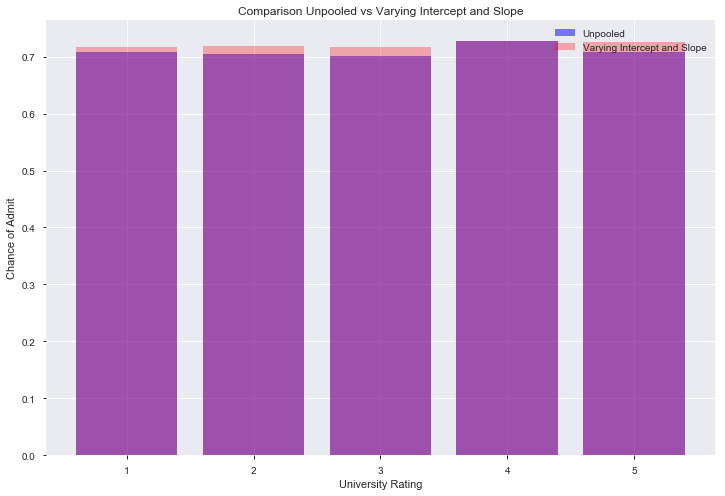

In [134]:
fig, ax = plt.subplots(figsize = (12,8))
x = []
for i in range(1,6):
    x.append(i) 

ax.bar(x,unpool, alpha = 0.5, color = 'blue')
ax.bar(x,varying, color = 'red',alpha = 0.3)
ax.set_title("Comparison Unpooled vs Varying Intercept and Slope")
ax.set_xlabel('University Rating')
ax.set_ylabel('Chance of Admit')
ax.legend(labels = ['Unpooled','Varying Intercept and Slope'])

## Model Comarison

In [135]:
pm.waic(pooled_trace, pooled_model)
#pm.waic(unpooled_trace, unpooled_model)
#pm.waic(partial_trace, partial_pooling)
pm.waic(varying_intercept_trace, varying_intercept_slope)

import arviz as az
compare = az.compare({'pool':pooled_trace, 'unpool':unpooled_trace, 'parital':partial_trace, 'both':varying_intercept_trace},
                    method='BB-pseudo-BMA')
compare

/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


rank     waic   p_waic   d_waic       weight       se      dse  \
pool       0 -1382.59  9.41179        0     0.591553  48.9147        0   
unpool     1 -1381.32  12.9951   1.2656     0.407543  48.4789  3.78532   
both       2 -1294.27  7.54272  88.3211  0.000903895  38.1846  20.4369   
parital    3 -854.119  6.25679   528.47   1.2547e-78  46.9029  46.5171   

        warning waic_scale  
pool       True   deviance  
unpool     True   deviance  
both      False   deviance  
parital   False   deviance